# ***IMPORT DATASET***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from numpy import array 

In [2]:
from sklearn.feature_selection import VarianceThreshold
dataset_train = pd.read_csv('/content/BABA (1).csv',index_col=['Date'])
X = dataset_train.iloc[:, 1:]
y = dataset_train.iloc[:, 0]
select = SelectKBest(score_func=f_regression, k=4)
z = select.fit_transform(X, y) 
filter = select.get_support()
features = array(dataset_train.columns)
print("All features:")
print(features)
print('Feature selection with SelectKBest:')
print(filter)
dataset_train = dataset_train.drop('Volume', axis=1)
print(dataset_train)



All features:
['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume']
Feature selection with SelectKBest:
[ True  True  True  True False]
                  Open        High         Low       Close   Adj Close
Date                                                                  
2021-12-06  113.639999  123.820000  113.430000  123.599998  123.599998
2021-12-07  129.300003  129.449997  123.459999  125.540001  125.540001
2021-12-08  123.209999  126.970001  121.320000  125.080002  125.080002
2021-12-09  124.629997  127.760002  123.211998  123.910004  123.910004
2021-12-10  123.220001  125.209999  122.779999  125.059998  125.059998
...                ...         ...         ...         ...         ...
2022-11-30   82.739998   89.625000   82.250000   87.559998   87.559998
2022-12-01   84.349998   87.599998   84.260002   85.940002   85.940002
2022-12-02   86.050003   91.849998   86.050003   90.059998   90.059998
2022-12-05   92.900002   92.900002   89.629997   90.519997   90.519997
2022-12-06   91

In [3]:
train = dataset_train.iloc[:238,:]
test = dataset_train.iloc[239:,:]
print(train.shape)
print(test.shape) 

(238, 5)
(14, 5)


In [4]:
dataset_train.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-12-06,113.639999,123.820000,113.430000,123.599998,123.599998
2021-12-07,129.300003,129.449997,123.459999,125.540001,125.540001
2021-12-08,123.209999,126.970001,121.320000,125.080002,125.080002
2021-12-09,124.629997,127.760002,123.211998,123.910004,123.910004
2021-12-10,123.220001,125.209999,122.779999,125.059998,125.059998


# ***PREPROCESSING DATA***

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train)

In [6]:
from statistics import mean
X_train = []
y_train = []
for i in range(60,238):
    X_train.append(training_set_scaled[i-60:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(178, 60, 5)
(178, 5)


In [7]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],X_train.shape[2]))
print(X_train.shape)

(178, 60, 5)


In [8]:
dataset_total = pd.concat((
    train, test), axis = 0)
inputs = dataset_total[len(dataset_total) -
                      len(test) - 60:].values
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60,74):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i])
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = sc.inverse_transform(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],X_test.shape[2]))

def to2dim(a):
  nsamples, nx, ny = a.shape
  a = a.reshape((nsamples,nx*ny))
  return a

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# ***RNN***

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout

In [61]:
RNN = Sequential()
RNN.add(SimpleRNN(units = 100, return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
RNN.add(SimpleRNN(units = 100, return_sequences = False))
RNN.add(Dense(units = 5))

RNN.compile(optimizer = 'adam', loss = 'mean_squared_error')

start_RNN = time.time()
RNN.fit(X_train, y_train, epochs = 5, batch_size = 32)
end_RNN =  time.time() - start_RNN

Epoch 1/5
6/6 [==============================] - 2s 35ms/step - loss: 0.2015
Epoch 2/5
6/6 [==============================] - 0s 36ms/step - loss: 0.0428
Epoch 3/5
6/6 [==============================] - 0s 39ms/step - loss: 0.0266
Epoch 4/5
6/6 [==============================] - 0s 41ms/step - loss: 0.0174
Epoch 5/5
6/6 [==============================] - 0s 38ms/step - loss: 0.0120


In [62]:
X_train_RNN = X_train[-1,-60:]
for i in range(14):
  a = np.array(X_train_RNN[-60:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_RNN = RNN.predict(a)
  X_train_RNN = np.append(X_train_RNN,predicted_RNN,axis=0)
predicted_RNN = sc.inverse_transform(X_train_RNN[-14:])[:,0].reshape(-1,1)

1/1 [==============================] - 0s 23ms/step


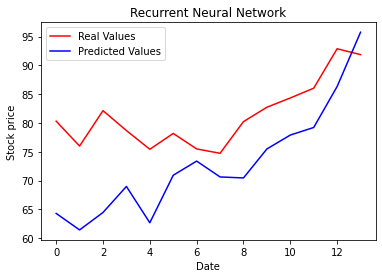

In [63]:
def plot_predictions(test, predicted, model_name):
    plt.plot(test, color="red", label="Real Values")
    plt.plot(predicted, color="blue", label="Predicted Values")
    plt.title(model_name)
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend()
    plt.show()
plot_predictions(y_test[:,0:1],predicted_RNN,'Recurrent Neural Network')

***RNN - Overfitting***

In [80]:
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss")

RNN_DROP = Sequential()
RNN_DROP.add(SimpleRNN(units = 100, return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
RNN_DROP.add(Dropout(0.2))
RNN_DROP.add(SimpleRNN(units = 100, return_sequences = False))
RNN_DROP.add(Dropout(0.2))
RNN_DROP.add(Dense(units = 5))

RNN_DROP.compile(optimizer = 'adam', loss = 'mean_squared_error')

start_RNN = time.time()
RNN_DROP.fit(X_train, y_train, epochs = 5, batch_size = 32,callbacks=[earlyStop], validation_split=0.2)
end_RNN =  time.time() - start_RNN

Epoch 1/5
5/5 [==============================] - 2s 123ms/step - loss: 0.3207 - val_loss: 0.0399
Epoch 2/5
5/5 [==============================] - 0s 48ms/step - loss: 0.2174 - val_loss: 0.0563


1/1 [==============================] - 0s 21ms/step


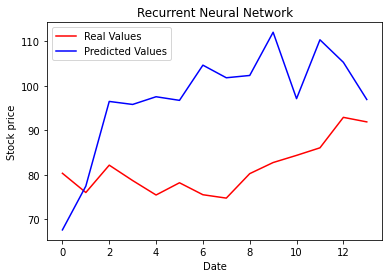

In [81]:
X_train_RNN_DROP = X_train[-1,-60:]
for i in range(14):
  a = np.array(X_train_RNN_DROP[-60:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_RNN_DROP = RNN_DROP.predict(a)
  X_train_RNN_DROP = np.append(X_train_RNN_DROP,predicted_RNN_DROP,axis=0)
predicted_RNN_DROP = sc.inverse_transform(X_train_RNN_DROP[-14:])[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1],predicted_RNN_DROP,'Recurrent Neural Network')

# ***LSTM***

In [102]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(16, return_sequences=True, input_shape= (X_train.shape[1],X_train.shape[2])))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(16))
model.add(Dense(5))

In [103]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
start_LSTM = time.time()
model.fit(X_train, y_train, batch_size=32, epochs=5)
end_LSTM =  time.time() - start_LSTM

Epoch 1/5
6/6 [==============================] - 4s 49ms/step - loss: 0.1933
Epoch 2/5
6/6 [==============================] - 0s 49ms/step - loss: 0.1151
Epoch 3/5
6/6 [==============================] - 0s 46ms/step - loss: 0.0633
Epoch 4/5
6/6 [==============================] - 0s 59ms/step - loss: 0.0404
Epoch 5/5
6/6 [==============================] - 0s 48ms/step - loss: 0.0298


In [104]:
X_train_LSTM = X_train[-1,-60:]
for i in range(14):
  a = np.array(X_train_LSTM[-60:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM = model.predict(a)
  X_train_LSTM = np.append(X_train_LSTM,predicted_LSTM,axis=0)
predicted_LSTM = sc.inverse_transform(X_train_LSTM[-14:])[:,0].reshape(-1,1)

1/1 [==============================] - 0s 23ms/step


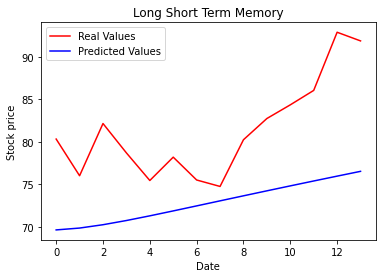

In [105]:
plot_predictions(y_test[:,0:1], predicted_LSTM, 'Long Short Term Memory')

***LSTM - Overfitting***

In [110]:
model_DROP = Sequential()
model_DROP.add(LSTM(32, return_sequences=True, input_shape= (X_train.shape[1],X_train.shape[2])))
model_DROP.add(Dropout(0.2))
model_DROP.add(LSTM(16, return_sequences=False))
model_DROP.add(Dropout(0.2))
model_DROP.add(Dense(8))
model_DROP.add(Dropout(0.2))
model_DROP.add(Dense(5))
model_DROP.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
start_LSTM = time.time()
model_DROP.fit(X_train, y_train, batch_size=32, epochs=5,callbacks=[earlyStop], validation_split=0.2)
end_LSTM =  time.time() - start_LSTM

Epoch 1/5
5/5 [==============================] - 5s 309ms/step - loss: 0.2730 - val_loss: 0.0134
Epoch 2/5
5/5 [==============================] - 0s 58ms/step - loss: 0.1424 - val_loss: 0.0117


1/1 [==============================] - 0s 23ms/step


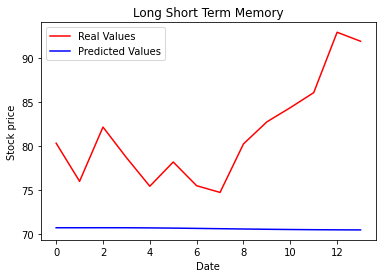

In [111]:
X_train_LSTM_DROP = X_train[-1,-60:]
for i in range(14):
  a = np.array(X_train_LSTM_DROP[-60:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM_DROP = model_DROP.predict(a)
  X_train_LSTM_DROP = np.append(X_train_LSTM_DROP,predicted_LSTM_DROP,axis=0)
predicted_LSTM_DROP = sc.inverse_transform(X_train_LSTM_DROP[-14:])[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1], predicted_LSTM_DROP, 'Long Short Term Memory')

# ***MLP***

In [21]:
MLP = Sequential()
MLP.add(Dense(80, activation='relu'))
MLP.add(Dense(40, activation='relu'))
MLP.add(Dense(20, activation='relu'))
MLP.add(Dense(units = 5))
MLP.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
start_MLP = time.time()
print(X_train.shape)
print(y_train.shape)
X_train_2dim = to2dim(X_train)
MLP.fit(X_train_2dim, y_train, batch_size=32, epochs=5)
end_MLP =  time.time() - start_MLP

(178, 60, 5)
(178, 5)
Epoch 1/5
6/6 [==============================] - 1s 4ms/step - loss: 0.2485
Epoch 2/5
6/6 [==============================] - 0s 4ms/step - loss: 0.0962
Epoch 3/5
6/6 [==============================] - 0s 4ms/step - loss: 0.0754
Epoch 4/5
6/6 [==============================] - 0s 4ms/step - loss: 0.0659
Epoch 5/5
6/6 [==============================] - 0s 4ms/step - loss: 0.0563


In [23]:
X_train_MLP = X_train_2dim[-1]
for i in range(14):
  a = np.array(X_train_MLP[-300:])
  a = np.reshape(a,(1,300))
  predicted_MLP = MLP.predict(a)
  X_train_MLP = np.append(X_train_MLP,predicted_MLP[0],axis=0)
predicted_MLP = sc.inverse_transform(np.array(X_train_MLP[-70:]).reshape(14,5))[:,0].reshape(-1,1)

1/1 [==============================] - 0s 18ms/step


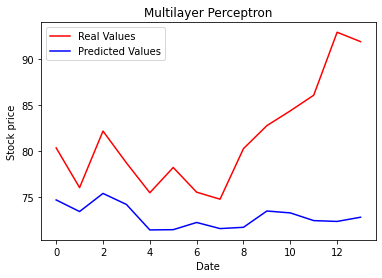

In [24]:
plot_predictions(y_test[:,0:1], predicted_MLP, 'Multilayer Perceptron')

***MLP - Overfitting***

In [25]:
MLP_DROP = Sequential()
MLP_DROP.add(Dense(80, activation='relu'))
MLP_DROP.add(Dropout(0.2))
MLP_DROP.add(Dense(40, activation='relu'))
MLP_DROP.add(Dropout(0.2))
MLP_DROP.add(Dense(20, activation='relu'))
MLP_DROP.add(Dropout(0.2))
MLP_DROP.add(Dense(units = 5))
MLP_DROP.compile(loss='mean_squared_error', optimizer='adam')

X_train_2dim = to2dim(X_train)
MLP_DROP.fit(X_train_2dim, y_train, batch_size=32, epochs=5,callbacks=[earlyStop], validation_split=0.2)
end_MLP =  time.time() - start_MLP

Epoch 1/5
5/5 [==============================] - 1s 40ms/step - loss: 0.2985 - val_loss: 0.0178
Epoch 2/5
5/5 [==============================] - 0s 12ms/step - loss: 0.1440 - val_loss: 0.0077


1/1 [==============================] - 0s 18ms/step


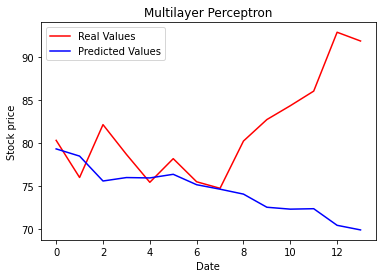

In [26]:
X_train_MLP_DROP = X_train_2dim[-1]
for i in range(14):
  a = np.array(X_train_MLP_DROP[-300:])
  a = np.reshape(a,(1,300))
  predicted_MLP_DROP = MLP_DROP.predict(a)
  X_train_MLP_DROP = np.append(X_train_MLP_DROP,predicted_MLP_DROP[0],axis=0)
predicted_MLP_DROP = sc.inverse_transform(np.array(X_train_MLP_DROP[-70:]).reshape(14,5))[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1], predicted_MLP_DROP, 'Multilayer Perceptron')

# ***SVR***

In [27]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr_rbf = MultiOutputRegressor(SVR(kernel= 'rbf', C= 50, gamma= 0.5))
start_SVR = time.time()
svr_rbf.fit(X_train_2dim, y_train)
end_SVR =  time.time() - start_SVR

In [28]:
X_train_SVR = X_train_2dim[-1]
for i in range(14):
  a = np.array(X_train_SVR[-300:])
  a = np.reshape(a,(1,300))
  predicted_SVR = svr_rbf.predict(a)
  X_train_SVR = np.append(X_train_SVR,predicted_SVR[0],axis=0)
predicted_SVR = sc.inverse_transform(np.array(X_train_SVR[-70:]).reshape(14,5))[:,0].reshape(-1,1)

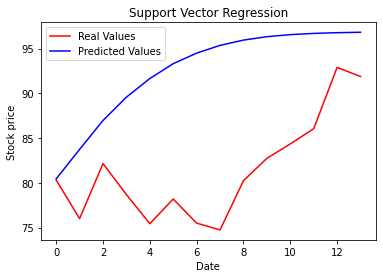

In [29]:
plot_predictions(y_test[:,0:1], predicted_SVR, 'Support Vector Regression')

# ***Random Forest***

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
start_RF = time.time()
rf.fit(X_train_2dim, y_train)
end_RF =  time.time() - start_RF

In [31]:
X_train_RF = X_train_2dim[-1]
for i in range(14):
  a = np.array(X_train_RF[-300:])
  a = np.reshape(a,(1,300))
  predicted_RF = rf.predict(a)
  X_train_RF = np.append(X_train_RF,predicted_RF[0],axis=0)
predicted_RF = sc.inverse_transform(np.array(X_train_RF[-70:]).reshape(14,5))[:,0].reshape(-1,1)

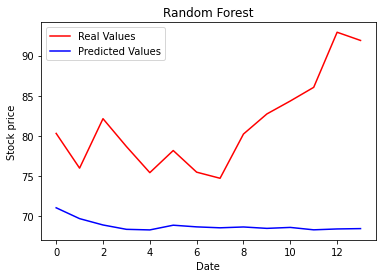

In [32]:
plot_predictions(y_test[:,0:1], predicted_RF, 'Random Forest')

# ***KNN***

In [121]:
from sklearn import neighbors

neighbor = neighbors.KNeighborsRegressor(n_neighbors = 3)
start_KNN = time.time()
neighbor.fit(X_train_2dim, y_train)
end_KNN =  time.time() - start_KNN

In [122]:
X_train_KNN = X_train_2dim[-1]
for i in range(14):
  a = np.array(X_train_KNN[-300:])
  a = np.reshape(a,(1,300))
  predicted_KNN = neighbor.predict(a)
  X_train_KNN = np.append(X_train_KNN,predicted_KNN[0],axis=0)
predicted_KNN = sc.inverse_transform(np.array(X_train_KNN[-70:]).reshape(14,5))[:,0].reshape(-1,1)
print(predicted_KNN)

[[71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]
 [71.170001]]


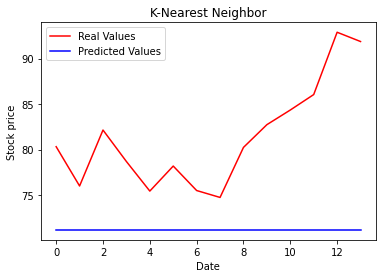

In [123]:
plot_predictions(y_test[:,0:1], predicted_KNN, 'K-Nearest Neighbor')

# ***Decision Tree***

In [36]:
from sklearn.tree import DecisionTreeRegressor

start_DT = time.time()
DT = DecisionTreeRegressor().fit(X_train_2dim, y_train)
end_DT =  time.time() - start_DT

In [37]:
X_train_DT = X_train_2dim[-1]
for i in range(14):
  a = np.array(X_train_DT[-300:])
  a = np.reshape(a,(1,300))
  predicted_DT = DT.predict(a)
  X_train_DT = np.append(X_train_DT,predicted_DT[0],axis=0)
predicted_DT = sc.inverse_transform(np.array(X_train_DT[-70:]).reshape(14,5))[:,0].reshape(-1,1)
print(predicted_DT)

[[73.160004]
 [73.160004]
 [71.599998]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]
 [73.160004]]


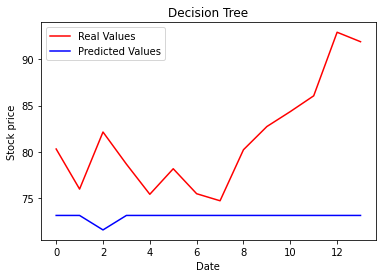

In [38]:
plot_predictions(y_test[:,0:1], predicted_DT, 'Decision Tree')

# ***Linear Regression***

In [39]:
from sklearn.linear_model import LinearRegression

start_LR = time.time()
LR = LinearRegression().fit(X_train_2dim, y_train)
end_LR =  time.time() - start_LR

In [40]:
X_train_LR = X_train_2dim[-1]
for i in range(14):
  a = np.array(X_train_LR[-300:])
  a = np.reshape(a,(1,300))
  predicted_LR = LR.predict(a)
  X_train_LR = np.append(X_train_LR,predicted_LR[0],axis=0)
predicted_LR = sc.inverse_transform(np.array(X_train_LR[-70:]).reshape(14,5))[:,0].reshape(-1,1)
print(predicted_LR)

[[73.160004  ]
 [73.42017916]
 [74.39451402]
 [75.26484861]
 [74.97326783]
 [73.23332559]
 [65.79502581]
 [60.4910051 ]
 [53.60900696]
 [56.54307585]
 [65.09097809]
 [64.9880208 ]
 [67.87555707]
 [69.46445404]]


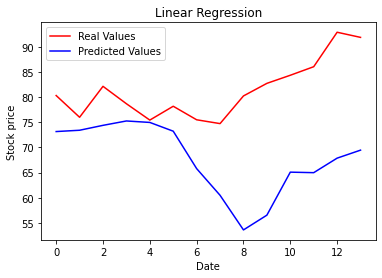

In [41]:
plot_predictions(y_test[:,0:1], predicted_LR, 'Linear Regression')

# ***LSTM + GRU***

In [132]:
from tensorflow.keras.layers import GRU

LSTM_GRU=Sequential()
LSTM_GRU.add(LSTM(128,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
LSTM_GRU.add(GRU(64))
LSTM_GRU.add(Dense(5))
LSTM_GRU.compile(loss='mean_squared_error',optimizer='adam')

In [133]:
start_LSTM_GRU = time.time()
LSTM_GRU.fit(X_train,y_train, epochs=5,batch_size=32)
end_LSTM_GRU =  time.time() - start_LSTM_GRU

Epoch 1/5
6/6 [==============================] - 6s 116ms/step - loss: 0.1084
Epoch 2/5
6/6 [==============================] - 1s 117ms/step - loss: 0.0229
Epoch 3/5
6/6 [==============================] - 1s 114ms/step - loss: 0.0156
Epoch 4/5
6/6 [==============================] - 1s 116ms/step - loss: 0.0112
Epoch 5/5
6/6 [==============================] - 1s 112ms/step - loss: 0.0108


In [134]:
X_train_LSTM_GRU = X_train[-1,-60:]
for i in range(14):
  a = np.array(X_train_LSTM_GRU[-60:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM_GRU = LSTM_GRU.predict(a)
  X_train_LSTM_GRU = np.append(X_train_LSTM_GRU,predicted_LSTM_GRU,axis=0)
predicted_LSTM_GRU = sc.inverse_transform(X_train_LSTM_GRU[-14:])[:,0].reshape(-1,1)

1/1 [==============================] - 0s 24ms/step


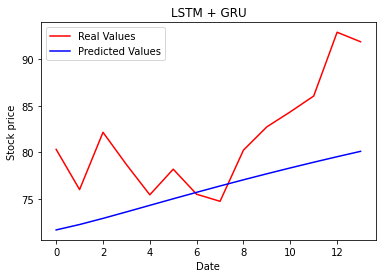

In [135]:
plot_predictions(y_test[:,0:1], predicted_LSTM_GRU, 'LSTM + GRU')

***LSTM + GRU - Overfitting***

In [142]:
LSTM_GRU_DROP=Sequential()
LSTM_GRU_DROP.add(LSTM(128,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
LSTM_GRU_DROP.add(Dropout(0.2))
LSTM_GRU_DROP.add(GRU(64))
LSTM_GRU_DROP.add(Dropout(0.2))
LSTM_GRU_DROP.add(Dense(5))
LSTM_GRU_DROP.compile(loss='mean_squared_error',optimizer='adam')

LSTM_GRU_DROP.fit(X_train,y_train, epochs=5,batch_size=32,callbacks=[earlyStop], validation_split=0.2)

Epoch 1/5
5/5 [==============================] - 5s 347ms/step - loss: 0.1271 - val_loss: 0.0279
Epoch 2/5
5/5 [==============================] - 1s 132ms/step - loss: 0.0400 - val_loss: 0.0055


1/1 [==============================] - 0s 30ms/step


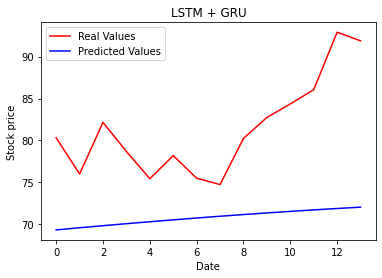

In [143]:
X_train_LSTM_GRU_DROP = X_train[-1,-60:]
for i in range(14):
  a = np.array(X_train_LSTM_GRU_DROP[-60:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM_GRU_DROP = LSTM_GRU_DROP.predict(a)
  X_train_LSTM_GRU_DROP = np.append(X_train_LSTM_GRU_DROP,predicted_LSTM_GRU_DROP,axis=0)
predicted_LSTM_GRU_DROP = sc.inverse_transform(X_train_LSTM_GRU_DROP[-14:])[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1], predicted_LSTM_GRU_DROP, 'LSTM + GRU')

# ***MSE, MAE & R2 SCORE***

In [144]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 


print('----------RNN----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_RNN))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_RNN))
print("R2 score:", r2_score(y_test[:,0:1], predicted_RNN))

print('----------LSTM----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_LSTM))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_LSTM))
print("R2 score:", r2_score(y_test[:,0:1], predicted_LSTM))

print('----------MLP----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_MLP))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_MLP))
print("R2 score:", r2_score(y_test[:,0:1], predicted_MLP))

print('----------SVR----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_SVR))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_SVR))
print("R2 score:", r2_score(y_test[:,0:1], predicted_SVR))

print('----------RANDOM FOREST----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_RF))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_RF))
print("R2 score:", r2_score(y_test[:,0:1], predicted_RF))

print('----------KNN----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_KNN))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_KNN))
print("R2 score:", r2_score(y_test[:,0:1], predicted_KNN))

print('----------DECISION TREE----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_DT))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_DT))
print("R2 score:", r2_score(y_test[:,0:1], predicted_DT))

print('----------LINEAR REGRESSION----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_LR))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_LR))
print("R2 score:", r2_score(y_test[:,0:1], predicted_LR))

print('----------LSTM + GRU----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_LSTM_GRU))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_LSTM_GRU))
print("R2 score:", r2_score(y_test[:,0:1], predicted_LSTM_GRU))

----------RNN----------
MSE:  100.54181754628496
MAE:  8.927341839000716
R2 score: -2.2081070728369867
----------LSTM----------
MSE:  90.82851918836818
MAE:  8.54417740041524
R2 score: -1.898173336575819
----------MLP----------
MSE:  103.26959107660666
MAE:  8.510219695764345
R2 score: -2.2951453795763097
----------SVR----------
MSE:  158.05131861037168
MAE:  11.107291951542972
R2 score: -4.043130962613883
----------RANDOM FOREST----------
MSE:  190.72171979209892
MAE:  12.536220807142858
R2 score: -5.085584218994207
----------KNN----------
MSE:  135.3944739942903
MAE:  10.200713428571431
R2 score: -3.320192137407565
----------DECISION TREE----------
MSE:  100.93300816716244
MAE:  8.322139428571429
R2 score: -2.2205892561542595
----------LINEAR REGRESSION----------
MSE:  270.7494184727135
MAE:  13.634767076749698
R2 score: -7.639122959647629
----------LSTM + GRU----------
MSE:  46.73373528526728
MAE:  5.672359240347403
R2 score: -0.49118874481991326


# ***TRANING TIME***

In [145]:
print('RNN:',end_RNN)
print('LTSM:',end_LSTM)
print('MLP:',end_MLP)
print('SVR:',end_SVR)
print('RANDOM FOREST:',end_RF)
print('KNN:',end_KNN)
print('DECISION TREE:',end_DT)
print('LINEAR REGRESSION:',end_LR)
print('LSTM + GRU:', end_LSTM_GRU)

RNN: 2.3853113651275635
LTSM: 5.692530393600464
MLP: 2.985459804534912
SVR: 0.023525714874267578
RANDOM FOREST: 1.842038631439209
KNN: 0.0008633136749267578
DECISION TREE: 0.036832332611083984
LINEAR REGRESSION: 0.038867950439453125
LSTM + GRU: 8.535932064056396


# ***COMPARE MODELS***

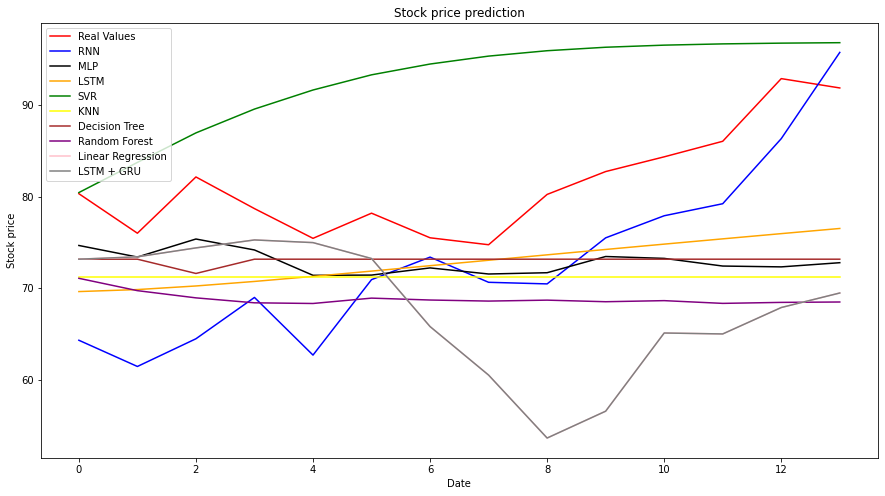

In [146]:
plt.figure(figsize=(15,8))
plt.plot(y_test[:,0:1], color="red", label="Real Values")
plt.plot(predicted_RNN, color="blue", label="RNN")
plt.plot(predicted_MLP, color="black", label="MLP")
plt.plot(predicted_LSTM, color="orange", label="LSTM")
plt.plot(predicted_SVR, color="green", label="SVR")
plt.plot(predicted_KNN, color="yellow", label="KNN")
plt.plot(predicted_DT, color="brown", label="Decision Tree")
plt.plot(predicted_RF, color="purple", label="Random Forest")
plt.plot(predicted_LR, color="pink", label="Linear Regression")
plt.plot(predicted_LR, color="gray", label="LSTM + GRU")
plt.title('Stock price prediction')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend()
plt.show()